# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## BAO theory and broadbands
The BAO broadband can be parameterized as:
- $k$ powers, $\sum_{i} (k / k_{p})^{i}$
- as sum of TSC or PCS kernels, $\sum_{i} K(k / k_{p} - i)$
where typically $k_{p} = 2\pi / r_{s}$.

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


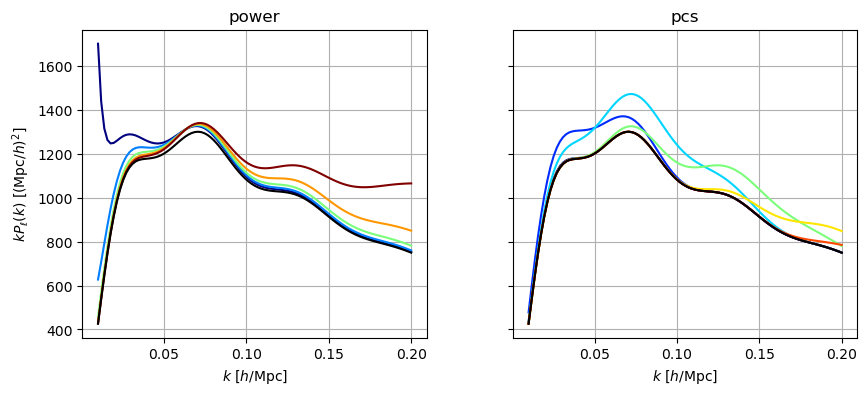

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles

template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template, broadband='power')

from matplotlib import pyplot as plt

fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, broadband in enumerate(['power', 'pcs']):
    ax = lax[iax]
    theory.init.update(broadband=broadband)
    names = theory.all_params.names(basename='*l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        pk = theory(**{name: 5e2 if broadband == 'power' else 1.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.k, theory.k * pk[ill], color=cmap(iname * 1. / len(names)))
        pk = theory(**{name: 0.})
    ax.plot(theory.k, theory.k * pk[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(broadband)
plt.show()

## BAO likelihood

In [3]:
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging

theory.init.update(broadband='pcs')
# Set damping sigmas to zero, as data follows linear pk
for param in theory.init.params.select(basename='sigma*'):
    param.update(value=0., fixed=True)
# Analytically solve for broadband parameters (named 'al*_*')
for param in theory.init.params.select(basename='al*_*'):
    param.update(derived='.auto')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.005, 0.2], 2: [0.005, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()

In [4]:
# Note, observable can take as input:
# - data: a (list of) (path to) PowerSpectrumStatistics object, flat array (see example below),
# or dictionary of parameters where to evaluate the theory to take as a mock data vector
# - covariance: a (list of) (path to) mocks, array (covariance matrix), or None (covariance passed to ObservablesGaussianLikelihood instead)

# Example, passing arrays:
ells = (0, 2)
k, pk = data(ell=ells, complex=False, return_k=True) # numpy array
mask = (k > 0.005) & (k < 0.2)
k = k[mask]  # array; one could also provide a list of k arrays, one for each ell
pk = np.ravel([pp[mask] for pp in pk])  # flat array
cov = np.cov([np.ravel([pp[mask] for pp in mock(ell=ells, complex=False)]) for mock in mocks], rowvar=False)  # array
observable = TracerPowerSpectrumMultipolesObservable(data=pk,
                                                     covariance=cov,
                                                     ells=ells,
                                                     k=k,
                                                     shotnoise=shotnoise,
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [5]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 3 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=3)

[000000.17] [0/1] 10-04 11:57  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1'].
[000001.17] [0/1] 10-04 11:57  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000001.22] [0/1] 10-04 11:57  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].


In [6]:
print(profiles.to_stats(tablefmt='pretty'))

+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 17) = 18.55 / 21 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qpar                 |  True  | 1.0023  | 0.0038 |
|                 qper                 |  True  | 0.9978  | 0.0069 |
|                  b1                  |  True  |  1.959  | 0.069  |
|                al0_-1                |  True  |   3.5   |        |
|                al0_0                 |  True  |  0.21   |        |
|                al0_1                 |  True  |  0.10   |        |
|                al0_2                 |  True  |  0.18   |        |
|                al0_3                 |  True  |  0.074  |        |
|                al0_4                 |  True  |  0.69   |        |
|                al0_5                 |  True  |  -950   |        |
|                al2_-1                |  True  |  0.49   |        |
|                al2_0            

[000036.84] [0/1] 10-04 11:57  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000036.84] [0/1] 10-04 11:57  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000036.95] [0/1] 10-04 11:57  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000036.96] [0/1] 10-04 11:57  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


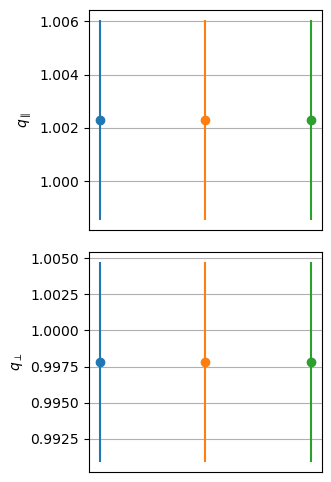

In [7]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper']);

[000037.04] [0/1] 10-04 11:57  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000037.07] [0/1] 10-04 11:57  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].


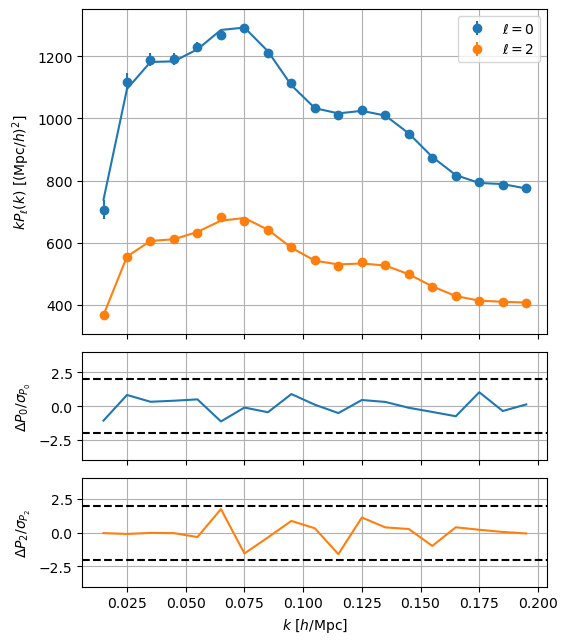

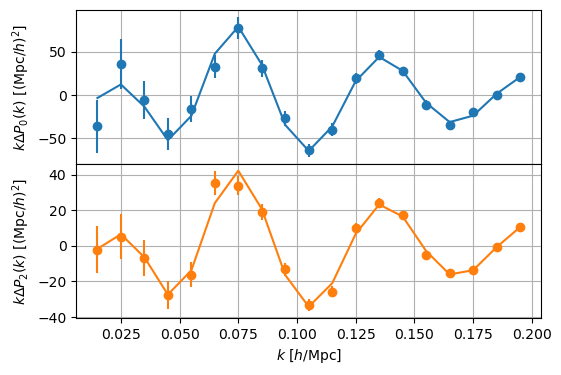

In [8]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot()
observable.plot_wiggles();

## Detection level

In [9]:
likelihood()
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000040.71] [0/1] 10-04 11:57  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000040.78] [0/1] 10-04 11:57  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000040.81] [0/1] 10-04 11:57  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].


In [10]:
template.init.update(only_now=False)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000150.11] [0/1] 10-04 11:59  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000150.17] [0/1] 10-04 11:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000150.20] [0/1] 10-04 11:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 16) = 19.40 / 22 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qiso                 |  True  | 1.0035  | 0.0036 |
|                  b1                  |  True  |  1.949  | 0.069  |
|                al0_-1                |  True  |   3.6   |        |
|                al0_0                 |  True  |  0.25

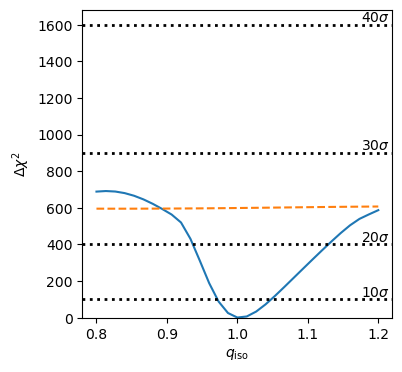

In [11]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40]);

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [12]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(min_iterations=500, check={'max_eigen_gr': 0.05, 'stable_over': 1})

[000273.59] [0/1] 10-04 12:01  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1'].
[000507.69] [0/1] 10-04 12:05  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000507.71] [0/1] 10-04 12:05  EmceeSampler              INFO     Diagnostics:
[000507.73] [0/1] 10-04 12:05  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.041; < 0.05.
[000507.74] [0/1] 10-04 12:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0388.
[000507.87] [0/1] 10-04 12:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.173.
[000507.87] [0/1] 10-04 12:05  EmceeSampler              INFO     - max Geweke is 0.597.
[000507.89] [0/1] 10-04 12:05  EmceeSampler              INFO     - Geweke p-value is 0.761.
[000507.89] [0/1] 10-04 12:05  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 11.6.


/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000684.98] [0/1] 10-04 12:08  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000684.99] [0/1] 10-04 12:08  EmceeSampler              INFO     Diagnostics:
[000685.00] [0/1] 10-04 12:08  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.143; not < 0.05.
[000685.01] [0/1] 10-04 12:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.112.
[000685.22] [0/1] 10-04 12:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.486.
[000685.22] [0/1] 10-04 12:08  EmceeSampler              INFO     - max Geweke is 0.316.
[000685.23] [0/1] 10-04 12:08  EmceeSampler              INFO     - Geweke p-value is 0.639.
[000685.23] [0/1] 10-04 12:08  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 15.5.
[000685.23] [0/1] 10-04 12:08  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.429.
[000852.80] [0/1] 10-04 12:11  Chain            

[Chain(shape=(2400, 6), params=ParameterCollection(['qiso', 'b1', 'logposterior', 'df', 'sigmas', 'sigmapar', 'sigmaper', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'loglikelihood', 'logprior', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5']))]

In [13]:
chain = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

+--------+--------+--------+--------+--------+-----------------+-----------------+
|        | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+--------+--------+--------+--------+--------+-----------------+-----------------+
|  qiso  | 1.0035 | 1.0035 | 1.0035 | 0.0035 | -0.0035/+0.0035 | -0.0041/+0.0029 |
|   b1   | 1.948  | 1.945  | 1.942  | 0.070  |  -0.069/+0.071  |  -0.074/+0.063  |
| al0_-1 |  3.6   |  3.6   |  3.6   |  2.7   |    -2.7/+2.7    |    -2.8/+2.7    |
| al0_0  |  0.25  |  0.26  |  0.28  |  0.38  |   -0.38/+0.37   |   -0.35/+0.39   |
| al0_1  |  0.11  |  0.11  |  0.12  |  0.23  |   -0.23/+0.23   |   -0.20/+0.25   |
| al0_2  |  0.21  |  0.22  |  0.24  |  0.32  |   -0.32/+0.32   |   -0.30/+0.34   |
| al0_3  |  0.02  |  0.02  |  0.02  |  0.26  |   -0.26/+0.26   |   -0.25/+0.26   |
| al0_4  |  1.1   |  1.2   |  1.2   |  1.1   |    -1.1/+1.1    |    -1.1/+1.1    |
| al0_5  | -1600  | -1600  | -1600  |  1300  |   -1300/+1200   |   -1300/+1200   |
| al

Removed no burn in


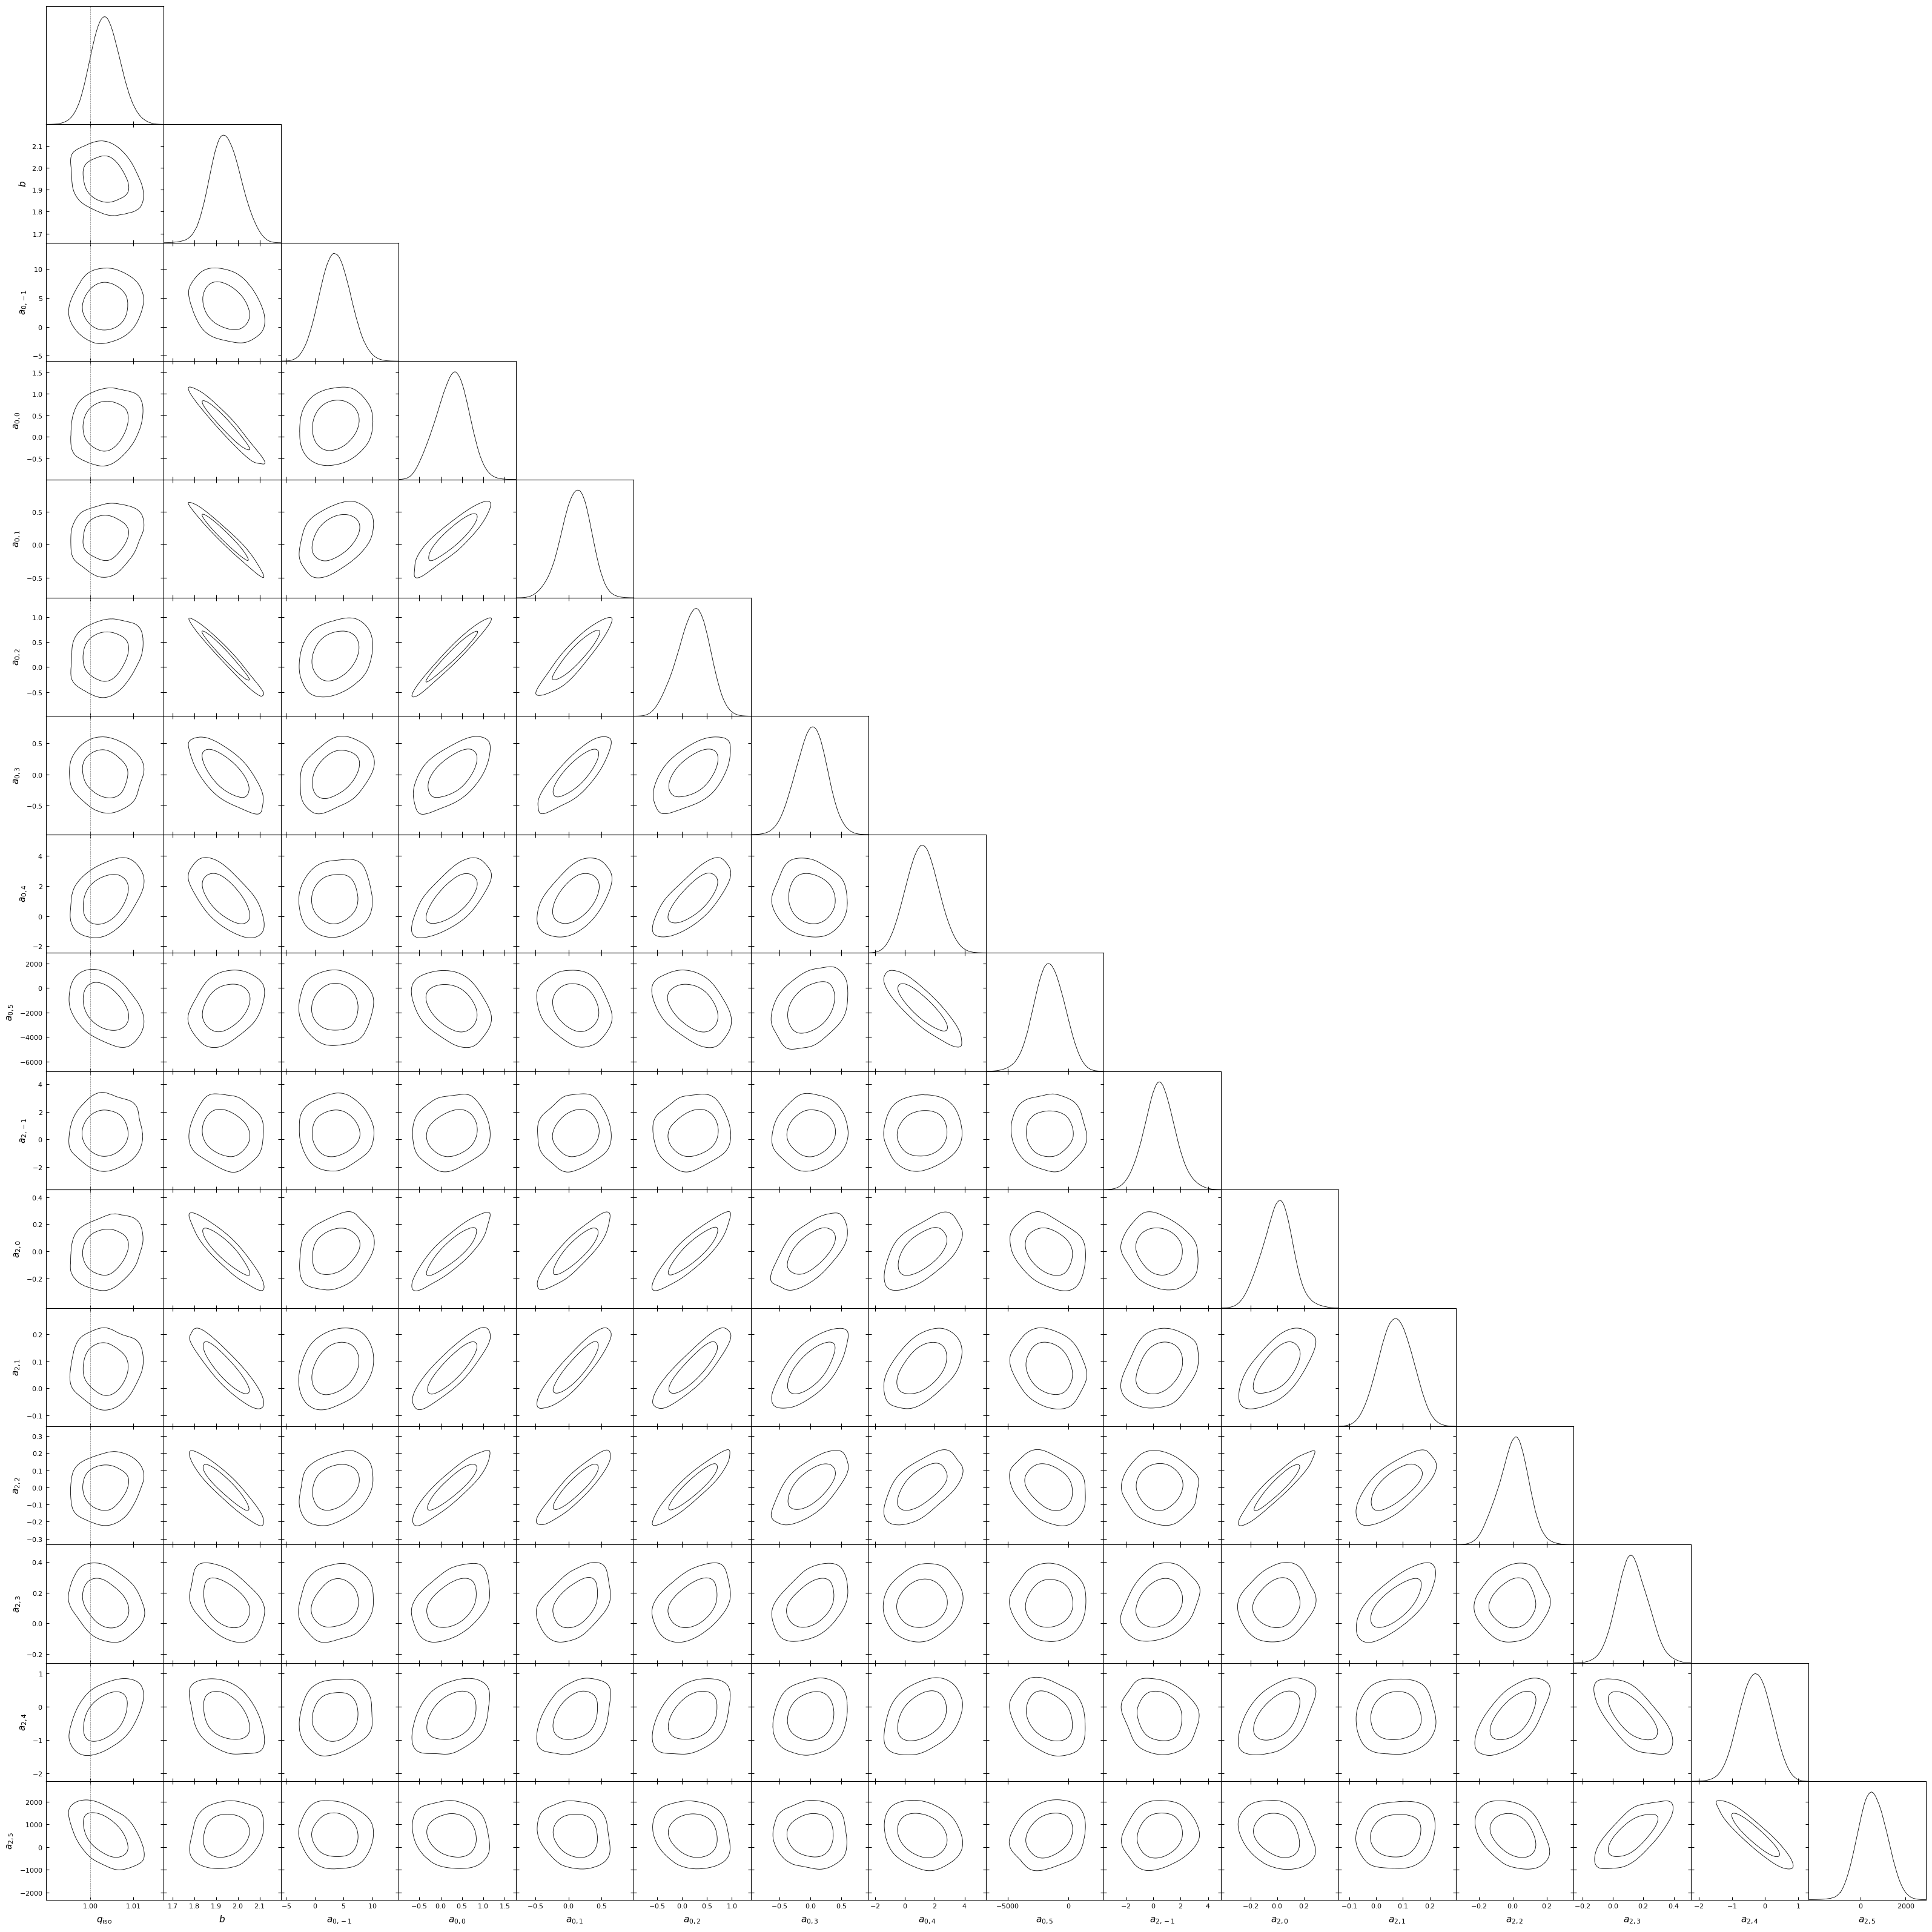

In [14]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})

## Post-processing
Let's use this BAO measurement to put constraints on $\Omega_{m}$.

In [15]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=['qiso'], fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

In [16]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.02})

[001781.23] [0/1] 10-04 12:26  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[001781.30] [0/1] 10-04 12:26  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[001848.63] [0/1] 10-04 12:27  EmceeSampler              INFO     Diagnostics:
[001848.63] [0/1] 10-04 12:27  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is -0.00295; < 0.02.
[001848.64] [0/1] 10-04 12:27  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is -0.00295.
[001848.68] [0/1] 10-04 12:27  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.111.
[001848.68] [0/1] 10-04 12:27  EmceeSampler              INFO     - max Geweke is 0.934.
[001848.68] [0/1] 10-04 12:27  EmceeSampler              INFO     - Geweke p-value is nan.
[001848.68] [0/1] 10-04 12:27  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 24.3.
[001909.83] [0/1] 10-04 12:28  EmceeSampler              INFO     Diagnostics:
[0

[Chain(shape=(600, 4), params=ParameterCollection(['Omega_m', 'logposterior', 'loglikelihood', 'logprior']))]

Removed no burn in


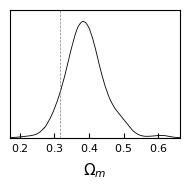

In [17]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.extractor.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})